In [16]:
import os
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from collections import Counter
import re
import spacy


Linking to a GitHub repository:

In [17]:
# GitHub repository URL and local path
repo_url = "https://github.com/stihem/DS821"
local_repo_path = os.path.join(os.getcwd(), "DS821")

# Clone the repository if it doesn't exist
if not os.path.exists(local_repo_path):
    os.system(f"git clone {repo_url} {local_repo_path}")
    print(f"Repository cloned to {local_repo_path}")
else:
    print("Repository already exists.")

Repository already exists.


Loading data from https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts 

In [18]:
# File path
file_path = os.path.join(local_repo_path, "reddit_wsb.csv")

# Check if the file exists
if os.path.exists(file_path):
    # Read the dataset
    combined_df = pd.read_csv(file_path, parse_dates=['timestamp'])
else:
    raise FileNotFoundError(f"The file {file_path} does not exist.")


Simplyfiing the data by combining the text in the title and body columns for later analysis and converting the timestamp to date only.

In [19]:
# Check if required columns exist
if 'timestamp' in combined_df.columns and 'title' in combined_df.columns and 'body' in combined_df.columns:
    # Select relevant columns and clean
    combined_df = combined_df[['timestamp', 'title', 'body']].fillna('')
    combined_df['full_text'] = combined_df['title'].str[:50] + '...' + combined_df['body'].str[:50]

    # Convert timestamp to date only
    combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp']).dt.date

    # Remove empty rows
    combined_df = combined_df[combined_df['title'] != '']

    # Sort the data chronologically by date
    combined_df = combined_df.sort_values(by='timestamp')

    # Display the data as a table (without the 'title' column)
    print("Data Preview:")
    display_df = combined_df[['timestamp', 'full_text']].head(10)  # Show the first 10 rows
    print(tabulate(display_df, headers='keys', tablefmt='fancy_grid', showindex=False))

else:
    print("Missing one or more required columns.")
    

Data Preview:
╒═════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ timestamp   │ full_text                                                                                               │
╞═════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ 2020-09-29  │ $CBAT $SUNW $SPI $OXBR Y'all are missing the point...$CBAT is going to be a great play further yet:     │
│             │                                                                                                         │
│             │ Th                                                                                                      │
├─────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ 2021-01-28  │ It's not about the money, it's about sending a mes...                                                   │
├─────────

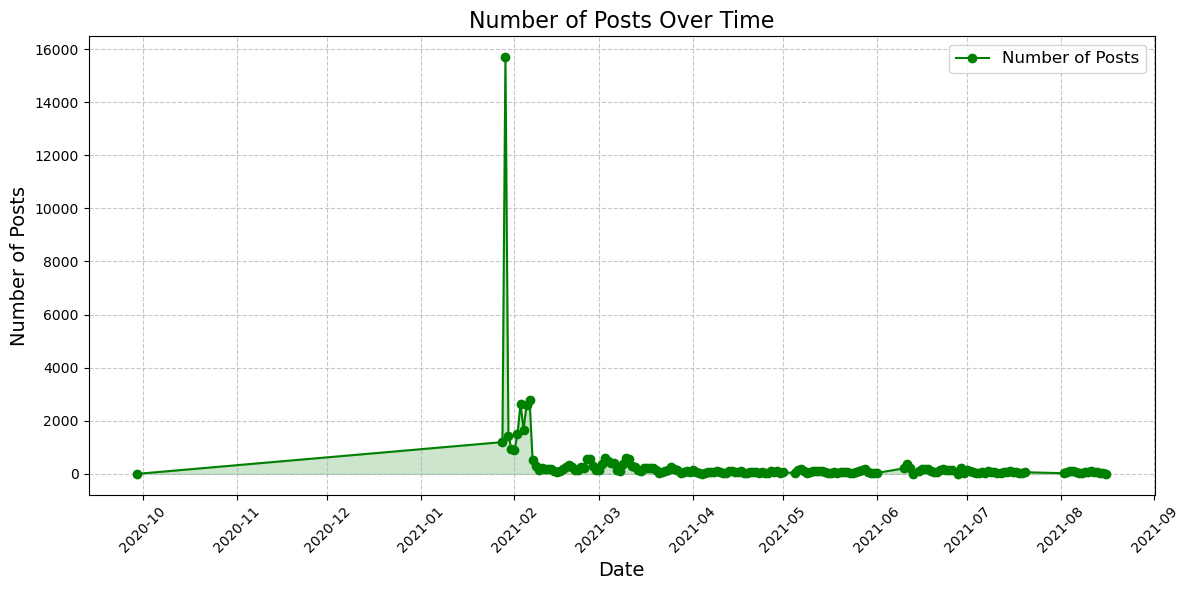

In [20]:
    # Aggregate data: count the number of posts per date
    post_counts = combined_df.groupby('timestamp').size()

    # Plot the data with date on the x-axis
    plt.figure(figsize=(12, 6))
    plt.plot(post_counts.index, post_counts.values, marker='o', linestyle='-', color='green', label='Number of Posts')
    plt.fill_between(post_counts.index, post_counts.values, color='green', alpha=0.2)  # Optional area shading

    # Format the plot
    plt.title('Number of Posts Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Posts', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()



This plot highlights a single post dated before 2021-21, which will be removed to create a more streamlined dataset. The plot also shows that the highsest concentration of post is around 202102 so going forward the data will be limited to the first two weeks (2021-01-28 to 2021-02-10) in order to condense the dataset for further analysis.

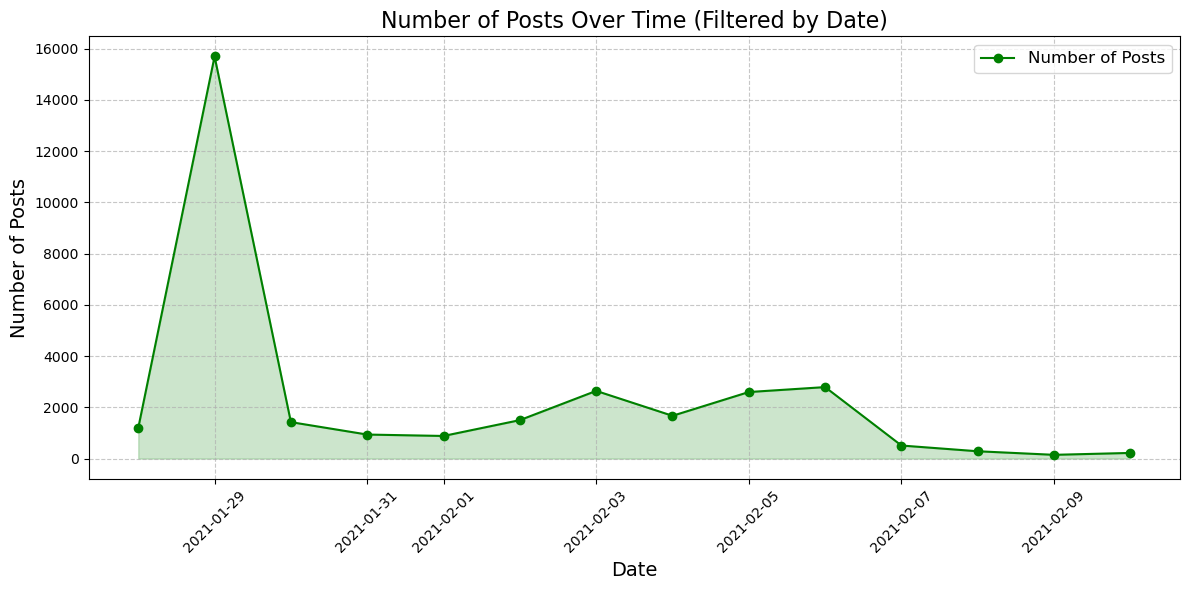

Filtered data has been saved in a list of dictionaries.
Number of records: 32511


In [21]:
# Check if required columns exist
if 'timestamp' in combined_df.columns and 'body' in combined_df.columns:
    # Reuse cleaned data: ensure 'full_text' column exists
    if 'full_text' not in combined_df.columns:
        combined_df = combined_df[['timestamp', 'body']].fillna('')
        combined_df['full_text'] = combined_df['body'].str[:50]  # Use truncated 'body' for full_text
        combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp']).dt.date
        combined_df = combined_df[combined_df['body'] != '']  # Remove rows with empty 'body'

    # Aggregate data: count the number of posts per date
    post_counts = combined_df.groupby('timestamp').size()

    # Filter data to the specified date range
    start_date = pd.to_datetime('2021-01-28').date()
    end_date = pd.to_datetime('2021-02-10').date()
    filtered_post_counts = post_counts.loc[start_date:end_date]

    # Check if filtered data is empty
    if filtered_post_counts.empty:
        print("No posts found within the specified date range.")
    else:
        # Plot the filtered data
        plt.figure(figsize=(12, 6))
        plt.plot(filtered_post_counts.index, filtered_post_counts.values, marker='o', linestyle='-', 
                 color='green', label='Number of Posts')
        plt.fill_between(filtered_post_counts.index, filtered_post_counts.values, color='green', alpha=0.2)

        # Update the plot title to reflect the filtering
        plt.title('Number of Posts Over Time (Filtered by Date)', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Number of Posts', fontsize=14)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12)

        # Finalize and show the plot
        plt.tight_layout()
        plt.show()

        # Save the filtered data into a list of dictionaries
        filtered_data = combined_df[(combined_df['timestamp'] >= start_date) & 
                                    (combined_df['timestamp'] <= end_date)]
        filtered_list = filtered_data[['timestamp', 'full_text']].to_dict(orient='records')

        # Confirmation message
        print("Filtered data has been saved in a list of dictionaries.")
        print(f"Number of records: {len(filtered_list)}")

else:
    print("Missing one or more required columns ('timestamp' or 'body').")


Before using the NLP tools of NER and AFINN to determine if the chat on reddit has any relation with the performance on the stock market, the data needs to be cleaned.

In [30]:
# Function to clean the text for analysis
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean the filtered list
def clean_filtered_list(filtered_list):
    cleaned_list = []
    for record in filtered_list:
        cleaned_text = clean_text(record['full_text'])
        if cleaned_text:  # Ensure cleaned text is not empty
            cleaned_record = {
                'timestamp': record['timestamp'],
                'full_text': cleaned_text
            }
            cleaned_list.append(cleaned_record)
    return cleaned_list


In [35]:
# Function to load ticker data
def load_ticker_data(file_name):
    __location__ = os.getcwd()  # Current working directory
    file_path = os.path.join(__location__, file_name)
    ticker_data = pd.read_csv(file_path)  # Load CSV file
    ticker_data.columns = ticker_data.columns.str.strip()  # Strip whitespace from column names
    return set(ticker_data['Ticker'].str.lower())  # Use 'Ticker' column, convert to lowercase

# Specify the correct file name
stock_ticker_file = "cleaned_stock_tickers.csv"

# Load ticker symbols
ticker_symbols = load_ticker_data(stock_ticker_file)

# Display the first 5 loaded tickers
print("Loaded Ticker Symbols:", list(ticker_symbols)[:5])

Loaded Ticker Symbols: ['mod', 'ctas', 'vst', 'etj', 'stpk']


In [36]:
# Function to extract stock tickers from text
def extract_tickers(docs, ticker_symbols):
    extracted_tickers = []
    for doc in docs:
        tickers = set()
        for token in doc:
            if token.text.lower() in ticker_symbols:  # Match tickers in lowercase
                tickers.add(token.text.upper())  # Add tickers in uppercase
        extracted_tickers.append(tickers)
    return extracted_tickers

# Example Input Data
filtered_list = [
    {"timestamp": "2024-06-01", "full_text": "AAPL and TSLA are performing well."},
    {"timestamp": "2024-06-02", "full_text": "Amazon stock AMZN is up 5% today!"},
    {"timestamp": "2024-06-03", "full_text": "VCVCU and TXG are hot stocks this week."},
    {"timestamp": "2024-06-04", "full_text": "Some random text with no ticker."},
]

# Apply Cleaning and NLP Processing
cleaned_filtered_list = clean_filtered_list(filtered_list)
docs = process_with_nlp(cleaned_filtered_list)

# Load Ticker Symbols and Extract Tickers
stock_ticker_file = "cleaned_stock_tickers.csv"  # Ensure this matches your file name
ticker_symbols = load_ticker_data(stock_ticker_file)
extracted_tickers = extract_tickers(docs, ticker_symbols)

# Display Results
for i, record in enumerate(cleaned_filtered_list):
    print(f"Record {i+1}:")
    print(f"Text: {record['full_text']}")
    print(f"Extracted Tickers: {extracted_tickers[i]}")


Record 1:
Text: aapl and tsla are performing well
Extracted Tickers: {'ARE', 'AAPL', 'TSLA', 'WELL'}
Record 2:
Text: amazon stock amzn is up today
Extracted Tickers: {'AMZN'}
Record 3:
Text: vcvcu and txg are hot stocks this week
Extracted Tickers: {'ARE', 'VCVCU', 'TXG'}
Record 4:
Text: some random text with no ticker
Extracted Tickers: set()
